# Neural Networks

* This notebook is adapted from [Aymeric Damian's neural network example](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/neural_network.ipynb)
* Clone the full collection [here](https://github.com/aymericdamien/TensorFlow-Examples).

Implementing a neural network (a.k.a multilayer perceptron) with TensorFlow

<center><img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 800px;"/></center>

## MNIST Dataset Overview


- 28x28 fixed size, black and white images
- Flattened to 784 features

<center><img src="http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png" alt="MNIST Dataset" style="width: 600px; height:400px;"/></center>

For this example, we will once again use the MNIST handwritten digits dataset. As mentioned in the previous lesson, this dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

TensorFlow makes this dataset available internally as part of the TensorFlow module, which means our data is just an import statement away.

In [1]:
import tensorflow as tf
logs_path = '../logs/lesson3'

## Tensorflow produces a lot of warnings. We generally want to suppress them. The below code does exactly that. 
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## **Architecture of the Neural Nework**

- 1 Input neuron for each pixel in image = 784 

- 2 Hidden layers with 256 neurons each

- 10 zero/one outputs - 1 for each digit

```python
n_hidden_1 = 256
n_hidden_2 = 256
num_input = 784
num_classes = 10
```

### Inputs = placeholders

```python
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])
```

In [3]:
# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, num_input], name = "InputData")
Y = tf.placeholder("float", [None, num_classes], name = "LabelData")

### Model weights

If we use the notation shown in the figure for our network, we can construct the weights as follows:

<center><img src="img/NNWithWeights.PNG" alt="nn" style="width: 800px;"/></center>


    
|<font size="5"> Source Layer </font>| <font size="5">       Destination layer      </font> | <font size="5"> Weight Tensor   </font>|
|--------------|-------------------|---------------|
| <font size="4"> Input     </font>   | <font size="4"> Hidden 1     </font>     | <font size="4"> h1     </font>       |
| <font size="4"> Hidden 1    </font> | <font size="4"> Hidden 2     </font>     | <font size="4"> h2     </font>       |
| <font size="4"> Hidden 2    </font> | <font size="4"> Output      </font>      | <font size="4"> out    </font>       |


```python
weights = {
    #weights between input layer and first hidden layer
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1]), name="HiddenWeight1"),
    #weights between first and second hidden layer
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]), name="HiddenWeight2"),
    #weights between second hidden layer and output layer
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]), name="OutputWeight")
}
```

```python
biases = {
    # Bias added to the first hidden layer
    'b1': tf.Variable(tf.random_normal([n_hidden_1]), name="Bias1"),
    # Bias added to second hidden layer
    'b2': tf.Variable(tf.random_normal([n_hidden_2]), name="Bias2"),
    # Bias added at the output layer
    'out': tf.Variable(tf.random_normal([num_classes]), name="OutputBias")
}
```

In [4]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1]), name="HiddenWeight1"),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]), name="HiddenWeight2"),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]), name="OutputWeight")
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1]), name="Bias1"),
    'b2': tf.Variable(tf.random_normal([n_hidden_2]), name="Bias2"),
    'out': tf.Variable(tf.random_normal([num_classes]), name="OutputBias")
}

We will now use these TensorFlow Variables that we have defined to build our neural network dataflow graph. 

### Defining the Neural Network 

- Output  = $f$(inputs, weights, bias)
- 2 densely connected layers

At each layer,
- output = $f\left(\mbox{input} \cdot \mbox{weights} + \mbox{bias}\right)$
   

To define the neural network architecture, we write the output as a function of the inputs, weights, and the bias. Our network has 2 densely connected hidden layers in between the input and output layers.  

A densely connected hidden layer, as the name suggests, has connections to each neuron in the previous layer as well as to each neuron in the next layer.

Each dense layer should implement the operation:

```python
output = activation(dot(input, weights) + bias)
``` 
where activation is the element-wise activation function, weights and bias are the weights matrix and bias vector we have initialized previously. 

The output layer will not be passed through an activation function

```python
# Input x is a tensor of dimension batch_size*744
def neural_net(x):
    # output = activation(dot(input, weights) + bias)
    layer_1 = tf.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2 = tf.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer
```

In [5]:
# Creating the model that we described above
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    with tf.name_scope('Layer1'):
        layer_1 = tf.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    # Hidden fully connected layer with 256 neurons
    with tf.name_scope('Layer2'):
        layer_2 = tf.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    # Output fully connected layer with a neuron for each class
    with tf.name_scope('Logits'):
        out_layer = (tf.matmul(layer_2, weights['out']) + biases['out'])
    return out_layer

## Loss function and optimizer

- Neural network outputs 10 logits
- Loss function for Multiclass classification => Cross Entropy loss
- Same as loss used for logistic regression.

* Implemented by TensorFlow's `softmax_cross_entropy_with_logits` with logits as input
* Trained using **AdamOptimizer**
    * SGD + independent learning rates for each feature + learning rates scaled by exponential averaging of past gradients

```python
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=labels))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
```

The _output_ from our neural network function is a _vector of logits_ that can be put through a softmax layer to get a vector of probabilities, one for each class, that sum up to 1.

The prediction would be the class that corresponds to the highest probability. Alternatively, because the softmax function is monotonic, the prediction would also be the class with the highest logit.

The most commonly used loss function to evaluate a multi-class classifier is a  **cross-entropy loss**, which is $-\sum_x p(x) \log q(x)$ , where $p(x)$ is 1 if the training sample belongs to class $x$ and $q(x)$ is the calculated probability that the training sample belongs to class $x$.

Neural networks can be trained easily using Gradient Descent. However, for large architectures, Gradient descent takes a long time to converge. Research in speeding up the convergence of Gradient Descent has led to the formulation of new training algorithms such as:
- **Adaptive Gradient Algorithm (AdaGrad)** : maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems)
- **Root Mean Square Propagation (RMSProp)** : maintains per-parameter learning rates which are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing).<br> This means the algorithm does well on online and non-stationary problems (e.g. noisy).
- **Adam Optimizer**: This combines the best parts of AdaGrad with the best parts of RMSProp. <br>Instead of an average of some recent magnitudes, Adam Optimizer keeps track of an exponential average of the gradient as well as the square of the gradient to scale the magnitude of the per-parameter learning rate. 

Adam has been emperically shown to work better than other learning algorithms. For a more comprehensive review, check out Sebastian Ruder's <a href="http://ruder.io/optimizing-gradient-descent/index.html">blog post</a> where he surveys and distills down the essence of recent developments in gradient descent based learning algorithms.

## Running the Graph in a session 

- Feed the training inputs using `feed_dict` parameter of Tensorflow `session`'s `run` function

```python
for each training_step:
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    sess.run(train_op, feed_dict={X: batch_x, Y: batch_y}) 
```

- Record loss and accuracy periodically


- After training finished: Call `session.run` once more
```python
loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y})
```

The last step is running the training and evaluation in a TensorFlow session.

An important concept to note here is that so far we have not specified the size of our training batch anywhere and that our model can be trained with any batch size. 

So, we can train using just 1 example at a time or even use all examples every training epoch. We will however, use batch gradient descent, so we feed in a batch at a time to the `feed_dict` parameter of our `sess.run` function call. 
```python
for each training_step:
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    sess.run(train_op, feed_dict={X: batch_x, Y: batch_y}) 
```

We can record the loss and accuracy as we did in Lesson 2 for logistic regression by running the corresponding components of the TensorFlow DataFlow Graph, `loss_op` and `accuracy`.

```python
loss, acc = sess.run(fetches = [loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y})
```

In [6]:
# hyper-parameters
num_steps = 2000
batch_size = 128
display_step = 100
logs=[]

for learning_rate in [0.1,0.01,0.001]:
    # Construct and executing the model described above
    print('\nusing learning_rate=',learning_rate)
    
    logits = neural_net(X)

    # Define loss and optimizer

    #The Softmax cross entropy with logits function originally did not allow backpropagation of errors through the errors.
    # However, this was deprecated in favor of a v2 method that permits the backpropagation of errors through the labels as well.
    #In order to recreate how the deprecated method used to work, 
    #we need to stop the gradient flowing through to the labels while using the v2 method.
    with tf.name_scope('ActualLabels'):
        labels = tf.stop_gradient(Y)

    with tf.name_scope('Loss'):
        loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))

    with tf.name_scope('SGD'):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op)

    with tf.name_scope('Prediction'):
        prediction = tf.argmax(logits, 1)

    #Check accuracy of prediction
    with tf.name_scope('Accuracy'):
        correct_pred = tf.equal(prediction, tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:
        # Run the initializer
        sess.run(init)
        summary_writer = tf.summary.FileWriter(logs_path + "/nn", graph=tf.get_default_graph())
        _steps=[];_train=[];_test=[]
        for step in range(1, num_steps+1):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            if step % display_step == 0 or step == 1:
                # Calculate batch loss and accuracy
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                     Y: batch_y})
                test_acc=sess.run(accuracy, feed_dict={X: mnist.test.images,
                                          Y: mnist.test.labels})
                print("Step " + str(step) 
                      + ", Minibatch Loss= " + "{:.4f}".format(loss) \
                      + ", Training Accuracy= " + "{:.3f}".format(acc) \
                      + ", Test  Accuracy=" + "{:.3f}".format(test_acc))
                _steps.append(step)
                _train.append(1-acc)
                _test.append(1-test_acc)

        print("Optimization Finished!")
        logs.append((learning_rate,_steps,_train,_test))
        # Calculate accuracy for MNIST test images
        print("Testing Accuracy:", \
            sess.run(accuracy, feed_dict={X: mnist.test.images,
                                          Y: mnist.test.labels}))



using learning_rate= 0.1
Step 1, Minibatch Loss= 24.2279, Training Accuracy= 0.203, Test  Accuracy=0.147
Step 100, Minibatch Loss= 0.9847, Training Accuracy= 0.664, Test  Accuracy=0.652
Step 200, Minibatch Loss= 0.6110, Training Accuracy= 0.859, Test  Accuracy=0.827
Step 300, Minibatch Loss= 0.5823, Training Accuracy= 0.758, Test  Accuracy=0.733
Step 400, Minibatch Loss= 0.8016, Training Accuracy= 0.820, Test  Accuracy=0.798
Step 500, Minibatch Loss= 0.5616, Training Accuracy= 0.852, Test  Accuracy=0.761
Step 600, Minibatch Loss= 0.8338, Training Accuracy= 0.812, Test  Accuracy=0.827
Step 700, Minibatch Loss= 0.7175, Training Accuracy= 0.773, Test  Accuracy=0.811
Step 800, Minibatch Loss= 0.6489, Training Accuracy= 0.773, Test  Accuracy=0.727
Step 900, Minibatch Loss= 0.6115, Training Accuracy= 0.836, Test  Accuracy=0.831
Step 1000, Minibatch Loss= 0.6617, Training Accuracy= 0.836, Test  Accuracy=0.740
Step 1100, Minibatch Loss= 0.4647, Training Accuracy= 0.906, Test  Accuracy=0.841
S

## Analysis of performance

* **Recall:** Logistic regression got an error of 12%

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Comparing performance for different learning rates

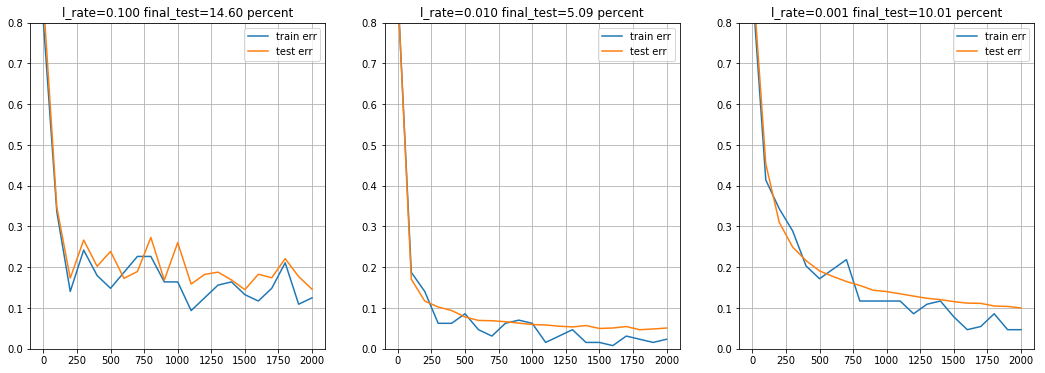

In [8]:
i=1;
figure(figsize=(18,6))
for learning_rate,_steps,_train,_test in logs:
    subplot(1,3,i)
    i+=1
    plot(_steps,_train,label='train err');
    plot(_steps,_test,label='test err');
    title('l_rate=%5.3f final_test=%4.2f percent'%(learning_rate,_test[-1]*100.))
    ylim([0,0.8])
    legend()
    grid()

### Tensorboard Visualization

If we view the TensorGraph we have defined using the Tensorboard tool, we see that we have succeeded in creating the model that we set out to 

<img src="img/NNTensorboard.PNG">

## Summary
This notebook demonstrated how to build a simple multi-layer neural network with basic TensorFlow API. 